In [1]:
import numpy as np
import xarray as xr
from scipy import stats
import cmaps
import sys
sys.path.append("..")

In [8]:
cmaps.GMT_polar

type: A colormap named "GMT_polar" is already registered.

In [3]:
fn = './03CMIP5/tas_Amon_bcc-csm1-1_rcp45_r1i1p1_200601-209912.nc'
cmip5 = xr.open_dataset(fn)
cmip5

<xarray.Dataset>
Dimensions:    (time: 1128, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/30)
    institution:            Beijing Climate Center(BCC),China Meteorological ...
    institute_id:           BCC
    experiment_id:          rcp45
    source:                 bcc-csm1-1:atmosphere:  BCC_AGCM2.1 (T42L26); lan...
    model_id:               bcc-csm1-1
    forcing:                Nat Ant GHG SD Oz Sl SS Ds BC OC
    ...                     ...
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.5.6
    NCO:                    4.7.3
    cp4cds_update_info:     As part of the Climate Projections for the Copern...
    source_tracking_id:     7a3294b8-e30b-414d-8ea2-969573312e3d

# 月平均转为季节平均

In [4]:
# 包装成一个简单的函数
def season_mean(ds, calendar='standard'):
    # 用每个月的天数制作一个DataArray，size= len（time）
    month_length = ds.time.dt.days_in_month

    # 通过按“ time.season”分组来计算权重
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # 测试每个季节的权重之和为1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    #计算加权平均值
    return (ds * weights).groupby('time.season').sum(dim='time')
tas_season = season_mean(cmip5.tas)

# 选取1月的长时间序列数据进行分析

In [5]:
tas_Jan = cmip5.tas.sel(time=cmip5.time.dt.month == 9)

# 趋势和P值计算

In [6]:
trend = np.zeros((tas_Jan.lat.shape[0],tas_Jan.lon.shape[0]))
p_value = np.zeros((tas_Jan.lat.shape[0],tas_Jan.lon.shape[0]))
# for i in range (0,tas_Jan.lat.shape[0]):
#     for j in range (0,tas_Jan.lon.shape[0]):
#         trend[i,j], intercept, r_value, p_value[i,j], std_err=stats.linregress(np.arange(94),tas_Jan[:,i,j])

## 等经纬度-全球

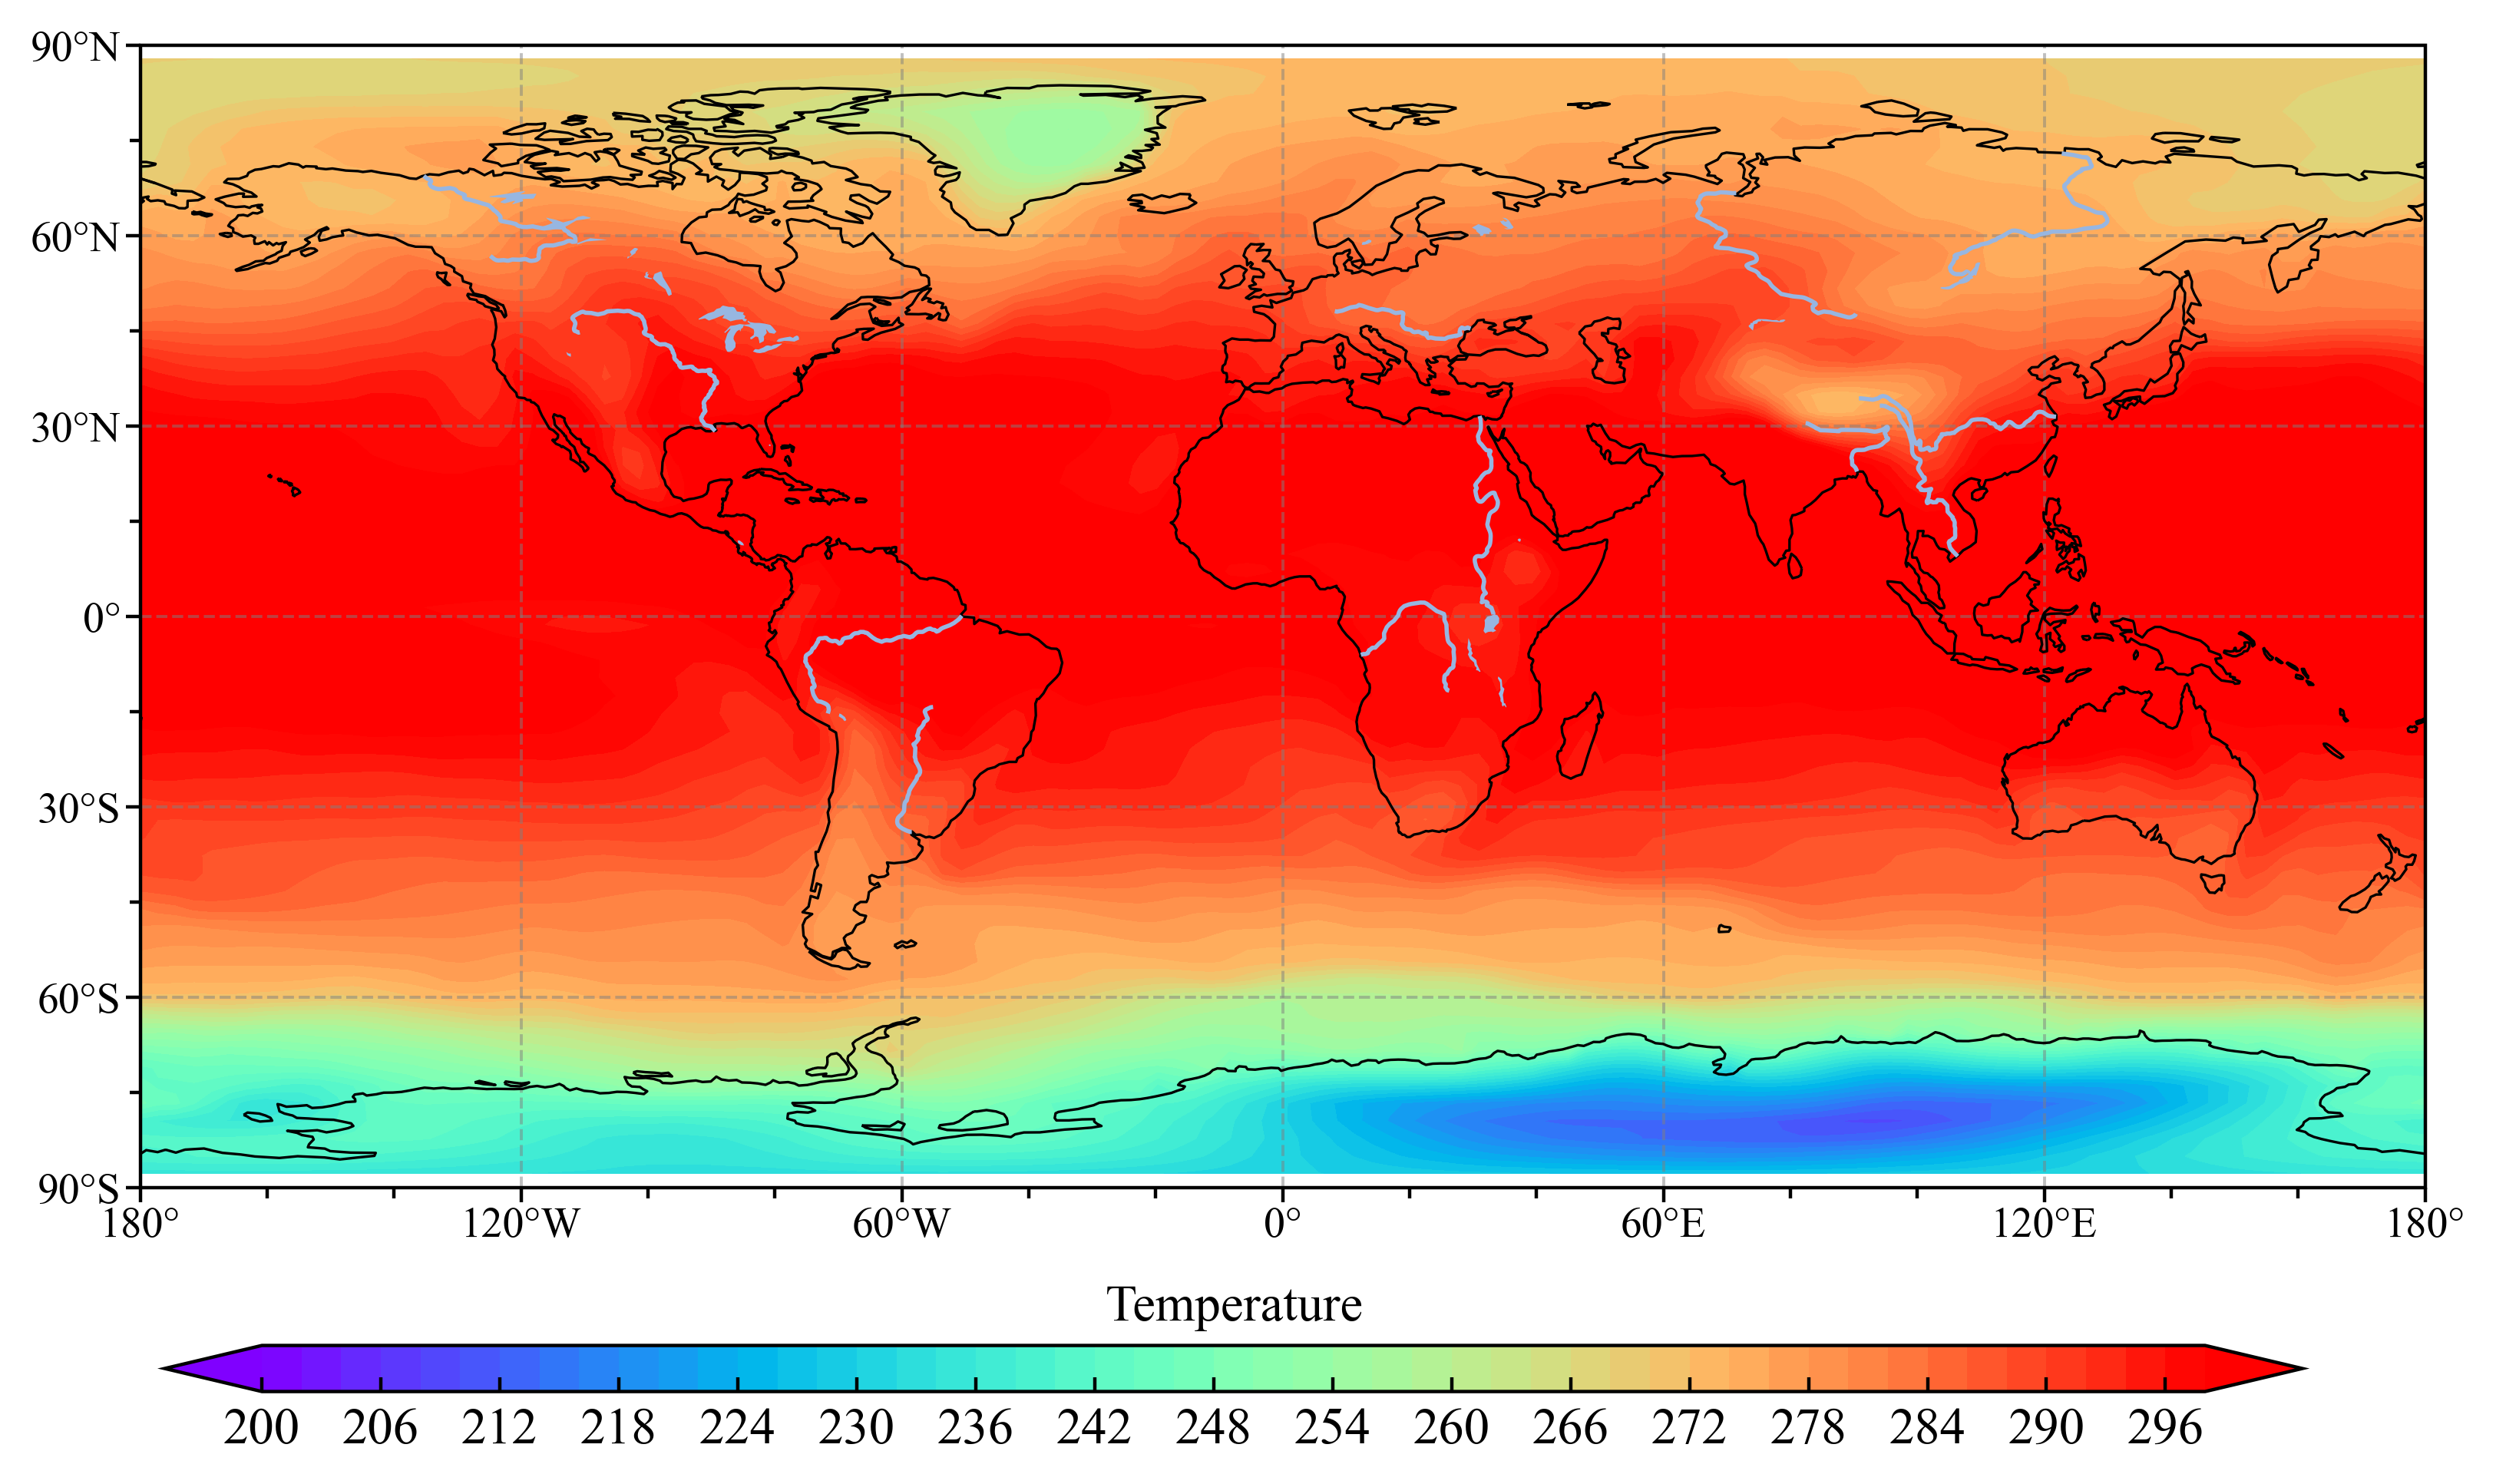

In [13]:
import draw_common
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.util as ucar

# bounds = np.arange(0.01,0.07,0.001)
bounds = np.arange(200,300,2)
midnorm = mcolors.Normalize(vmin=bounds[0], vmax=bounds[-1])

cycle_p, cycle_lon = ucar.add_cyclic_point(tas_Jan.values[0], coord=tas_Jan.lon)
cycle_LON,   cycle_LAT = np.meshgrid(cycle_lon, tas_Jan.lat)#解决中间白条

fig = draw_common.create_fig(flag=1)
axs = draw_common.create_map_PlateCarree_Globe(fig)
ctf = axs.contourf(
    cycle_LON,   cycle_LAT , cycle_p, 
    zorder=0,  
    extend = 'both', 
    # cmap=cmaps.GMT_polar,
    cmap= "rainbow",
    norm = midnorm,
    levels = bounds,
    transform=ccrs.PlateCarree(),
    )
# ctf1= axs.contourf(tas_Jan.lon, tas_Jan.lat,  p_value,[np.min(p_value),0.05,np.max(p_value)], 
#                    hatches=['.', None],zorder=1,colors="none", transform=ccrs.PlateCarree())
# 自动色标
# bar=fig.colorbar(ctf,ax=axs,orientation="horizontal",shrink=0.8,aspect=30,pad=0.1)  #aspect代表长宽比
# 调整子图之间的间距 为colorbar留出空间
plt.subplots_adjust(left=0.05, bottom=0.12, right=0.98, top=0.98, wspace=0.05, hspace=0.15)
# 绘制colorbar
cb = draw_common.create_colorbar(fig,"rainbow",bounds.tolist())

## 极地投影-南极

/Users/luoyp/Software/miniconda3/envs/py_new/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'cmaps'
  result = super().contourf(*args, **kwargs)


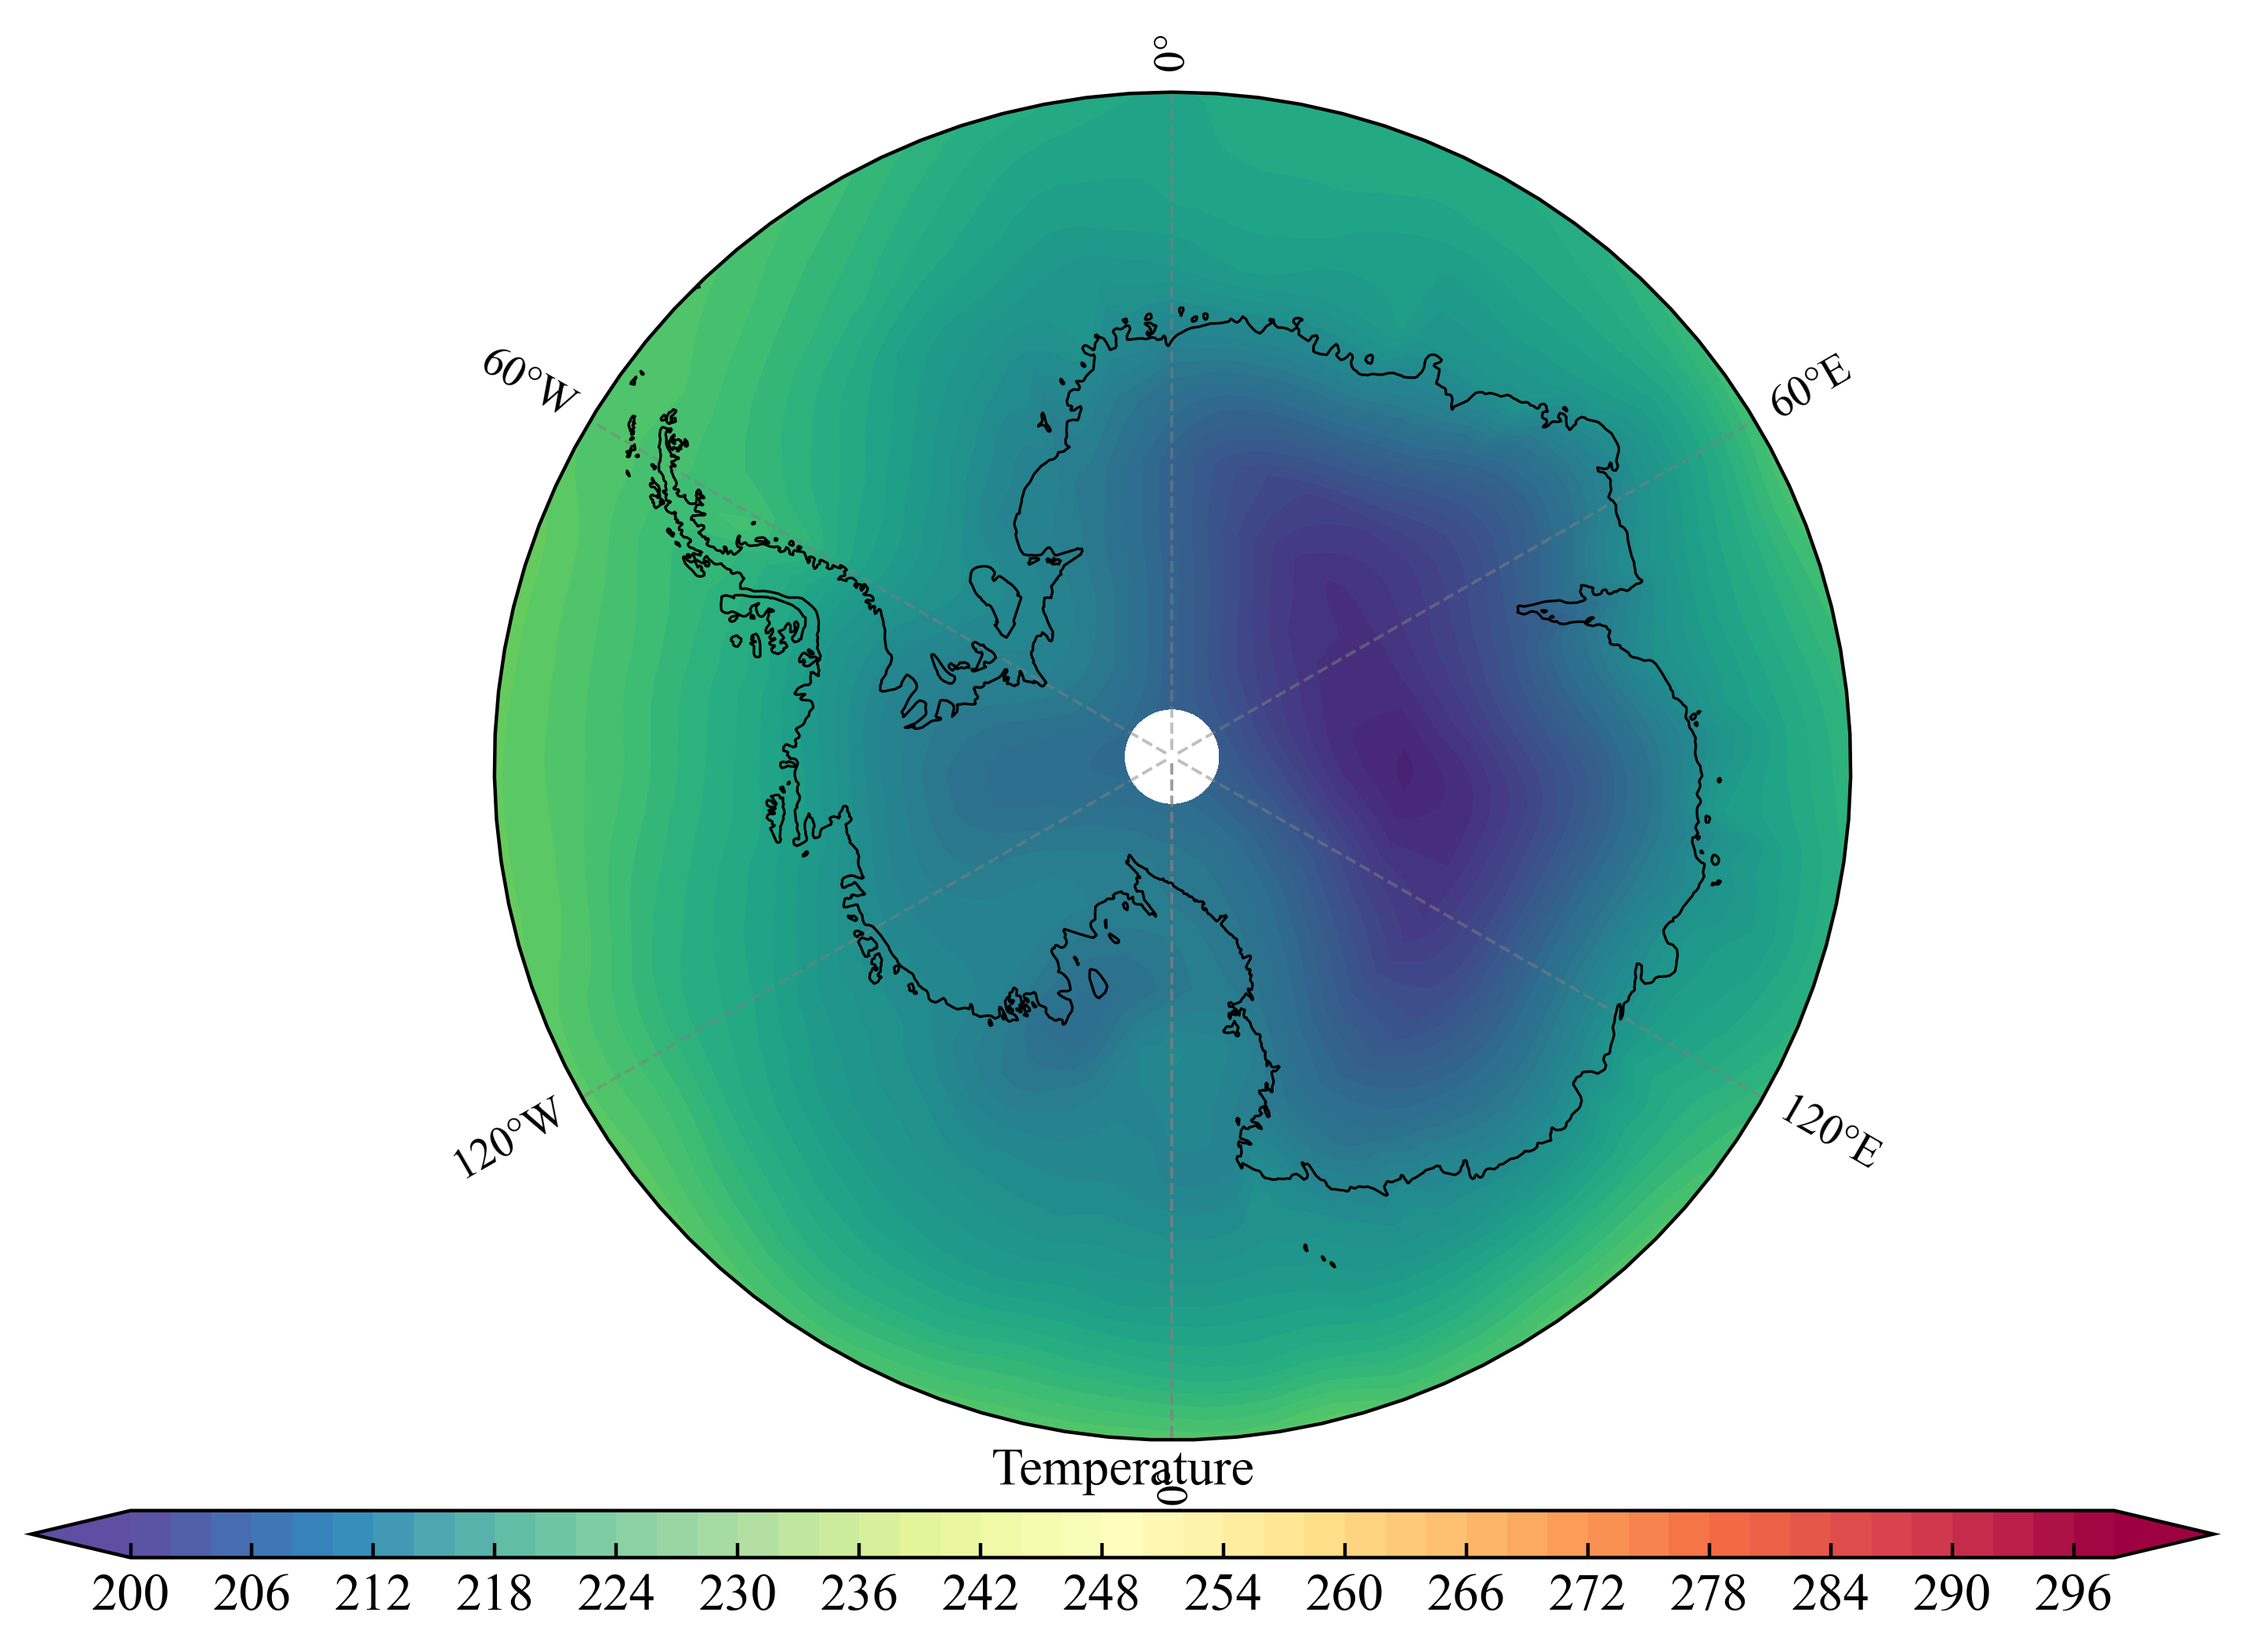

In [12]:
import draw_common
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

# bounds = np.arange(0.01,0.07,0.001)
bounds = np.arange(200,300,2)
midnorm = mcolors.Normalize(vmin=bounds[0], vmax=bounds[-1])

fig = draw_common.create_fig(flag=1)
axs = draw_common.create_map_PlateCarree_South(fig,boundary=True)
ctf = axs.contourf(
    cycle_LON,   cycle_LAT , cycle_p, 
    zorder=0,  
    extend = 'both', 
    # cmap=cmaps.GMT_polar,
    cmaps = "Spectral_r",
    norm = midnorm,
    levels = bounds,
    transform=ccrs.PlateCarree(),
    )
# ctf1= axs.contourf(tas_Jan.lon, tas_Jan.lat,  p_value,[np.min(p_value),0.05,np.max(p_value)], 
#                    hatches=['.', None],zorder=1,colors="none", transform=ccrs.PlateCarree())
# 自动色标
# bar=fig.colorbar(ctf,ax=axs,orientation="horizontal",shrink=0.8,aspect=30,pad=0.1)  #aspect代表长宽比
# 调整子图之间的间距 为colorbar留出空间
plt.subplots_adjust(left=0.05, bottom=0.12, right=0.98, top=0.98, wspace=0.05, hspace=0.15)
# 绘制colorbar
cb = draw_common.create_colorbar(fig,"Spectral_r",bounds.tolist())